In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import seaborn as sns

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/DBSCAN_data.csv")
data.columns =['X','Y']
data.head(10)

,X,Y
0,44.914873,75.058858
1,106.193470,142.420850
2,162.241870,120.278870
3,161.206290,119.607030
4,161.661160,116.450590
5,160.818650,120.437720
6,161.492710,118.919250
7,164.758590,121.334590
8,163.531750,122.374780
9,159.588860,118.221160


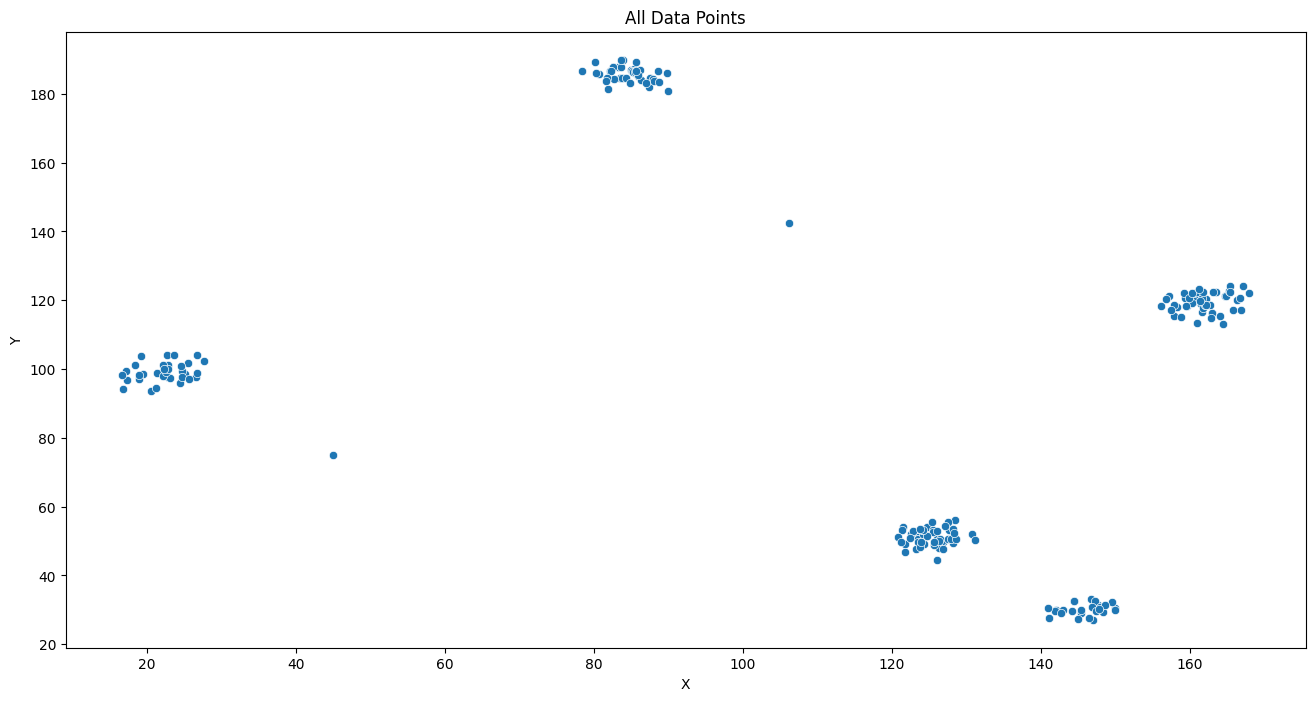

In [39]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(data=data, x='X', y='Y', ax=ax)
plt.title("All Data Points")
plt.show()

In [40]:
def check_point(eps,minPts, df, index):

    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']

    neighbors =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    #print(neighbors)
    if len(neighbors) >= minPts:
        #return (neighbors_index, is_core, is_border, is_noise)
        return (neighbors.index , True, False, False)

    elif (len(neighbors) < minPts) and len(neighbors) > 0:
        #return (neighbors_index, is_core, is_border, is_noise)
        return (neighbors.index , False, True, False)

    elif len(neighbors) == 0:
        #return (neighbors_index, is_core, is_border, is_noise)
        return (neighbors.index , False, False, True)

In [41]:
def fit_data(eps, minPts, df):

    #initiating cluster number
    cluster_count = 1
    current_set = set()
    unvisited = list(df.index)
    clusters = []


    while len(unvisited) > 0:

        first_point = True

        current_set.add(random.choice(unvisited))

        while len(current_set) > 0:

            curr_idx = current_set.pop()

            neigh_indexes, iscore, isborder, isnoise = check_point(eps, minPts, df, curr_idx)

            if (isborder==True & first_point==True):
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes, [0 for _ in range(len(neigh_indexes))])))#2,0 5,0 8,0

                # print('--------------------------------')
                # print(clusters)
                unvisited.remove(curr_idx)
                unvisited = [i for i in unvisited if i not in neigh_indexes]

                continue

            unvisited.remove(curr_idx)
            neigh_indexes = set(neigh_indexes) & set(unvisited)

            if iscore==True:
                first_point = False
                clusters.append((curr_idx,cluster_count))
                current_set.update(neigh_indexes)

            elif isborder==True:
                clusters.append((curr_idx,cluster_count))
                continue

            elif isnoise==True:
                clusters.append((curr_idx, 0))
                continue

        if first_point==False:
            cluster_count+=1

    return clusters


In [42]:
#radius of the circle defined
eps =  2
#minimum neighbouring points
minPts = 3
clustered_data = fit_data(eps, minPts, data)
#clustered_data

In [43]:
cluster_df = pd.DataFrame(clustered_data, columns = ["Index", "Cluster"])
cluster_df.head()

,Index,Cluster
0,7,1
1,8,1
2,41,1
3,42,1
4,43,1


In [44]:
cluster_df_xy = cluster_df.join(data, on='Index', lsuffix='_data', rsuffix='_cluster_df')
cluster_df_xy

,Index,Cluster,X,Y
0,7,1,164.758590,121.334590
1,8,1,163.531750,122.374780
2,41,1,165.256740,122.750400
3,42,1,165.383260,124.162530
4,43,1,167.128250,124.130890
...,...,...,...,...
204,34,0,156.857170,120.329740
205,111,0,16.694061,94.186722
206,166,0,89.997025,180.865730
207,174,0,80.124897,189.396200


In [45]:
cluster_df_xy["Cluster"] = cluster_df_xy["Cluster"].values.astype(str)
cluster_df_xy['Cluster'].mask(cluster_df_xy.Cluster == '0', 'outlier', inplace=True)

In [46]:
cnt=0;
num_cluster=pd.unique(cluster_df['Cluster'])#0,1,2,3,4,5
for i in range(np.size(num_cluster)):
  if num_cluster[i]==0:
    continue
  else:
    cnt+=1

print("Number of Cluster:",cnt)

num_outlier=cluster_df.query("Cluster==0").count()
print("Number of Outlie:r",num_outlier[1])

Number of Cluster: 5
Number of Outlie:r 28


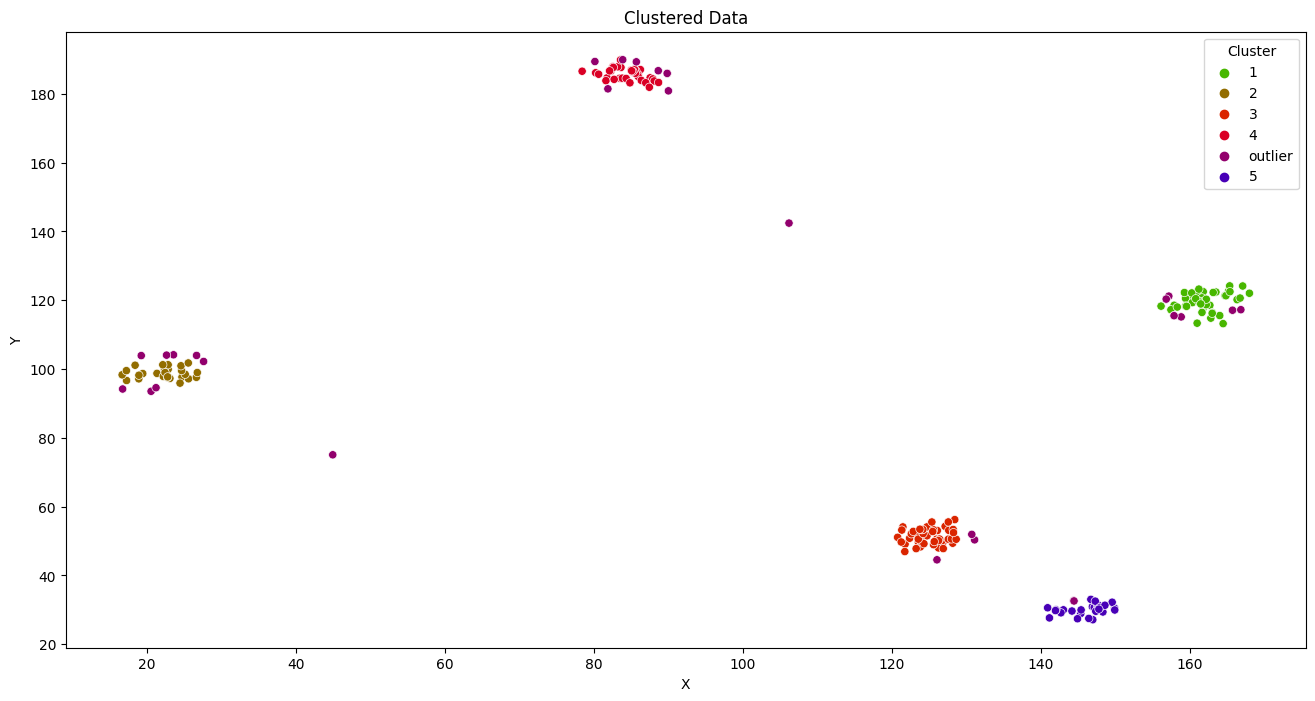

In [47]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(data=cluster_df_xy, x='X', y='Y', hue='Cluster', palette='brg_r', ax=ax)
# for i, txt in enumerate(cluster_df_xy.Y):
#     plt.annotate(f"({cluster_df_xy.X[i]}, {txt})", (cluster_df_xy.X[i], cluster_df_xy.Y[i]))
plt.title('Clustered Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()